In [3]:
from __future__ import division, print_function, absolute_import

import GPy
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
%matplotlib inline

from safe_learning import *

## Heads-up

The following code models an inverted pendulum, and uses a GP model to determine the safe region of attraction (ROA). The following is inteded to illustrate the algorithm, not to be high-performance code. As such, the code will run very slowly, with the main bottleneck being the repeated GP predictions of the dynamics. There are several obvious points that could make the code run faster
* A less conservative Lipschitz constant will allow coarser discretizations and therefore faster computations.
* Only evaluating states close to the boundary of the safe set, since those are the only states that are able to expand the ROA over time.
* Only partially update the GP predictions of the model where needed, rather than everywhere (lots of predictions are at states that are either unsafe and too far away from the current level set, or are already safe and evaluations there have no hope of expanding the ROA

## Dynamics model

We define the dynamics of an inverted pendulum
$$\ddot{\theta}(t) = \frac{mgl \sin(\theta(t)) + u(t)}{m l^2},$$
where $m$ is the mass, $g$ the gravitational constant, $l$ the length of the pendulum, $u$ the control input (torque), and $\theta$ the angle.

The prior model that we use considers no friction, as well as a mass that is $0.5\,$kg lighter.

In [4]:
n = 2
m = 1

# 'Wrong' model parameters
mass = 0.1
friction = 0.
length = 0.5
gravity = 9.81
inertia = mass * length ** 2

# True model parameters
true_mass = 0.15
true_friction = 0.05
true_length = length
true_inertia = true_mass * true_length ** 2

# Input saturation
x_max = np.deg2rad(30)
u_max = gravity * true_mass * true_length * np.sin(x_max)

# LQR cost matrices
Q = np.array([[1, 0], [0, 1]], dtype=np.float)
R = np.array([[0.1]], dtype=np.float)

## Normalization

In order for the LQR to return meaningful results, as well as for the GP model to have simpler kernel parameters, we normalize the system dynamics (all dimensions have similar magnitudes).

$\theta$ is normalized withing the maximum controllable angle, $\dot{\theta}$ is normalized with the eigenfrequency of the dynamics, and $u$ is normlized with the maximum allowed control input.

In [5]:
# Normalize the cost functions for the LQR computation
# x_normalized = inv(Tx) * x
Tx = np.diag([x_max, np.sqrt(gravity / length)])
Tu = np.array([[u_max]])

Tx_inv = np.diag(np.diag(Tx)**(-1))
Tu_inv = np.diag(np.diag(Tu)**(-1))
                
def normalize_x(x):
    """Normalize x vector"""
    x = np.asarray(x)
    return x.dot(Tx_inv)
                
def denormalize_x(x):
    """Denormalize x vector"""
    x = np.asarray(x)
    return x.dot(Tx)
                
def normalize_u(u):
    """Normalize u vector"""
    u = np.asarray(u)
    return u.dot(Tu_inv)

def denormalize_u(u):
    """Denormalize u vector"""
    u = np.asarray(u)
    return u.dot(Tu)

## Dynamics functions

Here we define the physical dynamics, as well as the prior dynamics, which are a linearization of the true, nonlinear model with wrong parameters.

In [6]:
# Nonlinear dynamics
def ode(x, u):
    """True ode of the dynamics.
    
    Parameters
    ----------
    x: np.array
        2D array with one, normalized state
        at each column
    u: np.array
        2D array with one, normalized input
        at each column
    
    Returns
    -------
    x_dot: np.array
        The normalized derivative of the dynamics
    """
    # Denormalize
    x = denormalize_x(np.atleast_2d(x))
    u = denormalize_u(np.asarray(u))
                
    # Physical dynamics
    x_dot = np.hstack([x[:, [1]],
                      (gravity / true_length * np.sin(x[:, [0]]) +
                       u / true_inertia
                       - true_friction / true_inertia * x[:, [1]])])
                
    # Normalize
    return normalize_x(x_dot)

# Linearized dynamics
A = np.array([[0, 1],
              [gravity / length, -friction / inertia]])

B = np.array([[0],
              [1 / inertia]])

# Normalize linear dynamics
An = Tx_inv.dot(A.dot(Tx))
Bn = Tx_inv.dot(B.dot(Tu))
    
# Obtain LQR controlelr gain and cost-to-go matrix
Kn, Pn = lqr(An, Bn, Q, R)


u_max_norm = normalize_u(u_max)
                
def control_law(x):
    """LQR controller with bounded (normalized) inputs.
    
    Parameters
    ----------
    x: np.array
        2D array with one normalized state on each column
        
    Returns
    -------
    u: np.array
        2D array with normalized inputs on each column
    """
    x = np.asarray(x)
    u = -x.dot(Kn.T)
    np.clip(u, -u_max_norm, u_max_norm, out=u)
    return u

def true_dynamics(x):
    """Return the true closed-loop, normalized dynamics.
    
    Parameters
    ----------
    x: np.array
        2D array with one normalized state on each column
        
    Returns
    -------
    x_dot: np.array
        2D array with normalized derivative states on each column
    """
    x = np.asarray(x)
    u = control_law(x)
    return ode(x, u)

def prior_dynamics(x):
    """Return the linearized, closed-loop, prior, normalized dynamics.
    
    Parameters
    ----------
    x: np.array
        2D array with one normalized state on each column
        
    Returns
    -------
    x_dot: np.array
        2D array with normalized derivative states on each column
    """
    x = np.asarray(x)
    u = control_law(x)
    return x.dot(An.T) + u.dot(Bn.T)

## Discretization

We discretize the state into a grid world. Since we will use the conservative, theoretical Lipschitz constant of $\dot{V}(x)$ from Lemma 5, we have to discretize very finely. In practice, one may be tempted to pick larger values.

In [27]:
# Discretization constant
tau = 0.002

# x_min, x_max, accuracy
grid_param = [(-0.5, 0.5, tau),
              (-0.5, 0.5, tau)]

# Used to plot the safe set later
extent = np.array([grid_param[0][0], grid_param[0][1],
                   grid_param[1][0], grid_param[1][1]])

# Define a grid with combinations of states
grid = [np.arange(*x) for x in grid_param]
num_samples = [len(x) for x in grid]
grid = combinations(grid)

# Initial safe set
grid_true = denormalize_x(grid)
S0 = np.logical_and(np.abs(grid_true[:, 0]) < np.deg2rad(5),
                    np.abs(grid_true[:, 1]) < np.deg2rad(10))

if not np.any(S0):
    print('No initial safe points!')
print('Grid size: {0} combinations in {1}x{2} discretized with tau={3}'
      .format(len(grid), extent[:2], extent[2:], tau))

Grid size: 250000 combinations in [-0.5  0.5]x[-0.5  0.5] discretized with tau=0.002


In [28]:
num_samples = [len(x) for x in grid]
print(num_samples)

1 [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

## Gaussian process model of the error

We define the state vector $\mathbf{x} = [\mathbf{x}_1, \mathbf{x}_2] = [\theta, \dot{\theta}]$, so that the dynamics can be written as
$$
\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2}
\end{matrix} \right]
$$

The first part of this equation says that the angle is equal to the integrated angular velocity. This is a intuitively true, irrespective of model errors. As such, we only learn the model error of the second part of the dynamics. That is
$$\dot{\mathbf{x}} =
\left[
\begin{matrix}
\mathbf{x}_2 \\
\frac{mgl \sin(\mathbf{x}_1) + \tau}{m l^2} + g_\pi(\mathbf{x})
\end{matrix} \right]
$$

As a kernel we choose $k(x,x') = k_{\mathrm{linear}}(x, x') * k_{\mathrm{Matern}}(x, x')$, the product of a linear and a Matern kernel. This encodes nonlinear functions with linearly increasing amplitude. For more details what this kernel encodes, see the one-dimensional example.

In [8]:
# Mean function for the GP with the prior dynamics
mf = GPy.core.Mapping(2, 1)
mf.f = lambda x: prior_dynamics(x)[:, [1]]
mf.update_gradients = lambda a,b: None

# Matern kernel multiplied with linear kernel
kernel = (GPy.kern.Matern32(input_dim=2, lengthscale=.2, variance=5, name='radial') *
          GPy.kern.Linear(input_dim=2, name='linear', variances=1))

# Measurement model
likelihood = GPy.likelihoods.Gaussian(variance=0.05**2)

# GP with initial measurement at (0, 0), 0
gp = GPy.core.GP(np.array([[0, 0]]), np.array([[0]]),
                 kernel, likelihood, mean_function=mf)


def predict_model(gp, x):
    """Predict the model using the gp dynamics
    
    Given that the model error only affects the second derivative,
    the first state has zero variance and is equal to the prior model.
    
    Parameters
    ----------
    gp: GPy.core.GP
        The GP model of the dynamics (including prior)
    x: np.array
        2D array. Each column has one state at which
        to predict the dynamics
        
    Returns
    -------
    mean: np.array
        The mean dynamics at x
    var: np.array
        Variance of the dynamics at x
    """
    gp_mean, gp_var = gp._raw_predict(x)
    # Augment with deterministic model for first state
    gp_mean = np.hstack([prior_dynamics(x)[:, [0]], gp_mean])
    gp_var = np.hstack([np.zeros_like(gp_var), gp_var])
    return gp_mean, gp_var

## Lipschitz constant

The Lipschitz constant is defined via the high-probability Lipschitz constant of the GP model, as well as the linear dynamics. Importantly, here we use the local Lipschitz constants. Since the kernel we have choosen implies increasing Lipschitz constants with distance from the origin. the worst-case Lipschitz constant would be too conservative.

In [9]:
# Lyapunov function:
V, dV = quadratic_lyapunov_function(grid, Pn)
V_max = np.max(V)
accuracy = V_max / 1e10

# Lipschitz constants of Lyapunov function
B_dV = L_V = np.max(np.abs(dV), axis=1)
L_dV = np.max(Pn)

# Kernel parameters
kernel_lengthscale = np.min(gp.kern.radial.lengthscale).squeeze()
kernel_var = gp.kern.radial.variance.values.squeeze()
linear_var = gp.kern.linear.Kdiag(grid).squeeze()

# Dynamics Lipschitz constants
L_g = 2 * np.sqrt(kernel_var * linear_var) / kernel_lengthscale
L_f = np.max(np.abs(An - Bn.dot(Kn)))

# Function bounds
B_g = 2 * np.sqrt(kernel_var * linear_var)
B_f = prior_dynamics(grid)[:, 1]

L = (B_g + B_f) * L_dV + B_dV * (L_g + L_f)

## True safe levelset

To get an intuition about the task at hand, we compute the maximum, safe level set (ROA) according to the true and prior dynamics. The learning algorithm only has access to the prior dynamics model, not the true model!

The plot shows the maximum level set (orange), and the region where $\dot{V}$ is sufficiently small (red). It can be seen that the prior model estimates a safe region that is too large, since it considers a lighter mass. Also, the third plot shows that we cannot recover the maximum level set with the learning method, since it considers $\dot{V}(x) < -L\tau$, rather than $\dot{V}(x) < 0$. For finer discretizations the two sets will get closer and closer to each other.

In [10]:
print(accuracy)

1.5296088963106665e-11


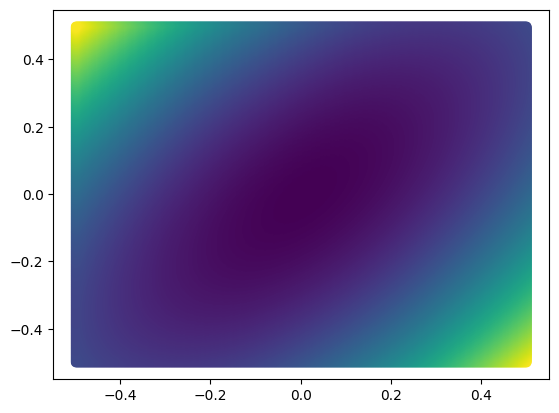

In [16]:
plt.scatter(-grid[:, 0], grid[:, 1], c=V, cmap='viridis')

[False False False ... False False False] [0.15296089 0.15239454 0.15182952 ... 0.15061281 0.15117557 0.15173965] 1.5296088963106665e-11
none,  <class 'numpy.float64'>
find 1.5296088963106665e-11
line, bound, accuracy [0, 0.15296088964636273] 1.5296088963106665e-11 True False
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
[0.024370646716172388, 0.024370646725075884]
line, bound, accuracy [0.024370646716172388, 0.024370646725075884] 1.5296088963106665e-11 True False
none,  <class 'numpy.float64'>
find 1.5296088963106665e-11
line, bound, accuracy [0, 0.15296088964636273] 1.5296088963106665e-11 True False
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line: 3
line:

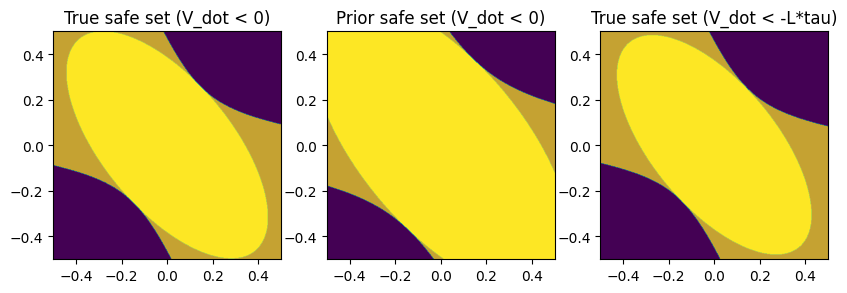

Number of true safe points:   133397/250000
Number of prior safe points:  184634/250000
Number of finite safe points: 124487/250000



In [17]:
V_dot_true = compute_v_dot_upper_bound(dV, true_dynamics(grid), None)
V_dot_prior = compute_v_dot_upper_bound(dV, prior_dynamics(grid), None)

fig, axes = plt.subplots(1, 3, figsize=(10, 20))

S_true = get_safe_set(V_dot_true, 0, S0=None)
axes[0].imshow(np.reshape(S_true, num_samples).T, extent=extent, origin='lower')
print(S_true, V, accuracy)
c_true = find_max_levelset(S_true, V, accuracy)
axes[0].imshow(np.reshape(V <= c_true, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
axes[0].set_title('True safe set (V_dot < 0)')

S_prior = get_safe_set(V_dot_prior, 0, S0=S0)
c_prior = find_max_levelset(S_prior, V, accuracy)
axes[1].imshow(np.reshape(S_prior, num_samples).T, extent=extent, origin='lower')
axes[1].set_title('Prior safe set (V_dot < 0)')
axes[1].imshow(np.reshape(V < c_prior, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')

S_true_L = get_safe_set(V_dot_true, -L*tau, S0=S0)
c_true_L = find_max_levelset(S_true_L, V, accuracy)
axes[2].imshow(np.reshape(S_true_L, num_samples).T, extent=extent, origin='lower')
axes[2].set_title('True safe set (V_dot < -L*tau)')
axes[2].imshow(np.reshape(V < c_true_L, num_samples).T, extent=extent, origin='lower', alpha=0.3, cmap='viridis')
plt.show()

print('Number of true safe points:   {0}/{3}\n'
      'Number of prior safe points:  {1}/{3}\n'
      'Number of finite safe points: {2}/{3}\n'.format(np.count_nonzero(V < c_true),
                                                       np.count_nonzero(V < c_prior),
                                                       np.count_nonzero(V < c_true_L),
                                                       grid.shape[0]))

## Online learning

Now let us see how the learning algorithm performs. We compute the maximum level set based on the GP estimate of the dynamics, and sample the most uncertain state within for 100 iterations.

In [14]:
V, dV = quadratic_lyapunov_function(grid, Pn)
    
def update_gp():
    dynamics_mean, dynamics_var = predict_model(gp, grid)
    V_dot = compute_v_dot_upper_bound(dV, dynamics_mean, dynamics_var, beta=2.)
    S = get_safe_set(V_dot, -L*tau, S0=S0)
    c = find_max_levelset(S, V, accuracy)
    S[:] = V <= c
    max_id = np.argmax(dynamics_var[S, 1])
    max_state = grid[S][[max_id], :].copy()

    print(c, S, max_id, max_state)
    gp.set_XY(np.vstack([gp.X, max_state]),
              np.vstack([gp.Y, true_dynamics(max_state)[:, [1]]]))
    return S

##### Warning: This is non-optimized, academic code. Executing the following cell may take roughly a minute on a decent laptop.

In [15]:
# Try to import a nice progress bar
try:
    from tqdm import tqdm
except:
    tqdm = lambda x: x
    
# Update the GP model 100 times
for i in tqdm(range(10)):
    S = update_gp()
    
print('Number of estimated safe points: {0}% relative to true dynamics with V_dot < 0'
      .format(np.count_nonzero(S) / np.count_nonzero(V < c_true)))

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.03it/s]

0.015559263897272812 [False False False ... False False False] 2838 [[-0.302  0.376]]
0.015537127047133649 [False False False ... False False False] 82401 [[ 0.304 -0.374]]
0.015289486395844593 [False False False ... False False False] 86 [[-0.344  0.192]]


 40%|████      | 4/10 [00:00<00:00, 10.87it/s]

0.015382774996841906 [False False False ... False False False] 84078 [[ 0.344 -0.186]]
0.01533557926724691 [False False False ... False False False] 58912 [[ 0.114 -0.37 ]]


 70%|███████   | 7/10 [00:00<00:00,  8.81it/s]

0.015217136474873397 [False False False ... False False False] 25079 [[-0.112  0.368]]
0.015153239612753982 [False False False ... False False False] 4857 [[-0.272  0.006]]


 90%|█████████ | 9/10 [00:01<00:00,  7.64it/s]

0.014669677099984879 [False False False ... False False False] 76008 [[ 0.272 -0.014]]
0.014384254847977895 [False False False ... False False False] 33623 [[-0.038 -0.266]]


100%|██████████| 10/10 [00:01<00:00,  8.32it/s]

0.014373991752988605 [False False False ... False False False] 45088 [[0.038 0.266]]
Number of estimated safe points: 0.5899008223573243% relative to true dynamics with V_dot < 0


# Plot results

We plot the resulting estimate. By restricting ourselves to the levelset $\dot{V} \leq -L \tau$, we cannot reach the true safe set. However, if we pick a less conservative Lipschitz constant and discretize at a finer rate, the two will approach each other.

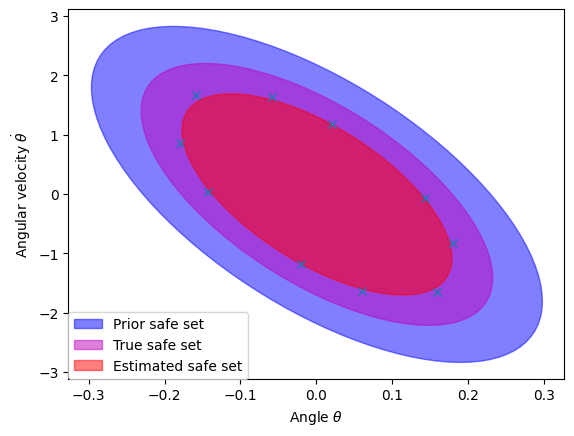

In [16]:
def denorm_ellipse(P, level):
    """Return the ellipse _bounds, but denormalized."""
    x0, x1_u, x1_l = ellipse_bounds(P, level)
    return Tx[0,0] * x0, Tx[1,1] * x1_u, Tx[1,1] * x1_l

c_est = find_max_levelset(S, V, accuracy)
colors = ['b', 'm', 'r']

plt.fill_between(*denorm_ellipse(Pn, c_prior), color=colors[0], alpha=0.5)
plt.fill_between(*denorm_ellipse(Pn, c_true), color=colors[1], alpha=0.5)
plt.fill_between(*denorm_ellipse(Pn, c_est), color=colors[2], alpha=0.5)

patch0 = patches.Patch(color=colors[0], alpha=0.5, label='Prior safe set')
patch1 = patches.Patch(color=colors[1], alpha=0.5, label='True safe set')
patch2 = patches.Patch(color=colors[2], alpha=0.5, label='Estimated safe set')

legs = [patch0, patch1, patch2]
labels = [x.get_label() for x in legs]
leg = plt.legend(legs, labels, loc=3, borderaxespad=0)

data = denormalize_x(gp.X[1:, :])
plt.plot(data[:, 0], data[:, 1], 'x')

plt.xlabel(r'Angle $\theta$')
plt.ylabel(r'Angular velocity $\dot{\theta}$')
plt.show()

In [1]:
grid

NameError: name 'grid' is not defined